# 0. Library

In [32]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle
import os
import torch

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # Added cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold # Added for feature selection

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
# import scorecardpy as sc # For LR+WOE variant (Keep commented if not using)

# --- Bayesian Optimization ---
import optuna # Added Optuna

# --- Display Options ---
# Set display options (optional but helpful)
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', 100)    # Show more rows
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Utility Function + Configuration

## 1.1 Helper Function

In [33]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


## 1.2 Early Stopping

In [34]:
# Define custom early stopping callbacks for Optuna
class EarlyStoppingCallback:
    """Stop optimization when the best score doesn't improve for a given number of trials."""
    def __init__(self, patience=10, min_improvement=0.001):
        self.patience = patience
        self.min_improvement = min_improvement
        self.best_score = None
        self.no_improvement_count = 0
        
    def __call__(self, study, trial):
        current_score = trial.value
        
        # Skip if the trial failed
        if current_score is None:
            return False
        
        # Initialize best_score for the first time
        if self.best_score is None:
            self.best_score = current_score
            return False
            
        # Check if current score improved
        improvement = current_score - self.best_score if study.direction == optuna.study.StudyDirection.MAXIMIZE else self.best_score - current_score
        
        if improvement > self.min_improvement:
            self.best_score = current_score
            self.no_improvement_count = 0
            print(f"New best score: {self.best_score:.4f}")
        else:
            self.no_improvement_count += 1
            print(f"No improvement for {self.no_improvement_count}/{self.patience} trials. Current best: {self.best_score:.4f}")
            
        # Stop if no improvement for patience trials
        if self.no_improvement_count >= self.patience:
            print(f"Early stopping triggered after {self.patience} trials without {self.min_improvement:.4f} improvement")
            return True
            
        return False

class TimeoutCallback:
    """Stop optimization after a specified amount of time."""
    def __init__(self, timeout=3600):  # timeout in seconds (default: 1 hour)
        self.start_time = time.time()
        self.timeout = timeout
        
    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.timeout:
            print(f"Timeout: optimization stopped after {elapsed_time/60:.2f} minutes")
            return True
        return False

## 1.3 Configuration

In [35]:
# --- GPU Configuration for PyTorch ---
def setup_device():
    """Setup and configure PyTorch device (GPU if available)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print GPU information
        gpu_props = torch.cuda.get_device_properties(0)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Set memory usage behavior
        torch.backends.cudnn.benchmark = True  # May speed up training if input sizes don't vary
        # torch.backends.cudnn.deterministic = True  # Uncomment for full reproducibility (but slower)
        
        # Optional: Set PyTorch to allocate memory as needed rather than all at once
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.9)  # Use up to 90% of GPU memory
            
        # Print memory usage
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
        
        # Check if MPS is available (Apple Silicon GPU)
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon GPU (MPS)")
    
    # Set default dtype for better numerical precision if needed
    # torch.set_default_dtype(torch.float32)  # Default is already float32
    # For reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    return device

# Set up device
device = setup_device()

Using GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB
CUDA Version: 12.6
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


In [36]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/' # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True) # Create output dir if needed
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
OPTUNA_N_TRIALS = 20 # Number of trials for Optuna optimization (adjust as needed)

# --- Check for GPU ---
# Define device_name globally before any model uses it
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Data Loading and Preprocessing

## 2.1 Loading, Preprocess

In [37]:
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train_final.csv')
    test_df = pd.read_csv(DATA_PATH + 'test_final.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 775)
Test shape: (61502, 775)


In [38]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 773)
Prepared X_test shape: (61502, 773)
Number of features: 773


## 2.2 Featue Selection

- Step:
    + Remove Low Variance Features
    + Remove Correlated Features

In [39]:
# --- Feature Selection: Low Variance Filter ---
print("\nApplying Low Variance Feature Selection...")
var_selector = VarianceThreshold(threshold=0.01) # Threshold=0 removes zero-variance, 0.01 removes low variance

# Fit on training data only
var_selector.fit(X_train)

# Get the boolean mask of selected features
feature_mask = var_selector.get_support()
original_feature_names = X_train.columns.tolist() # Get original names before transformation
selected_feature_names = [name for name, selected in zip(original_feature_names, feature_mask) if selected]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after variance thresholding: {len(selected_feature_names)}")

# Transform both X_train and X_test
X_train_np_selected = var_selector.transform(X_train)
X_test_np_selected = var_selector.transform(X_test)

# Convert back to DataFrame with selected column names
X_train = pd.DataFrame(X_train_np_selected, columns=selected_feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_np_selected, columns=selected_feature_names, index=X_test.index)

# Update the global feature_names list
feature_names = selected_feature_names

print(f"Updated X_train shape: {X_train.shape}")
print(f"Updated X_test shape: {X_test.shape}")


Applying Low Variance Feature Selection...
Original number of features: 773
Number of features after variance thresholding: 542
Updated X_train shape: (246005, 542)
Updated X_test shape: (61502, 542)


# 3. Model 1: Logistic Regression + WOE

In [40]:
# # --- Model 1: Logistic Regression + WOE (Special Handling) ---
# print("\n" + "="*60)
# print("Model 1: Logistic Regression + WOE")
# print("="*60)

# # Step 1.1: WOE Binning (Fit ONLY on Training Data)
# # Filter features with IV > 0.02 (common practice)
# # Handle potential infinite values after Response Encoding if needed before WOE
# X_train_woe_input = X_train.replace([np.inf, -np.inf], np.nan) # Replace inf
# X_test_woe_input = X_test.replace([np.inf, -np.inf], np.nan)

# # Impute remaining NaNs before WOE binning (median for numeric)
# # Consider if specific imputation was done before saving CSVs
# num_cols = X_train_woe_input.select_dtypes(include=np.number).columns
# for col in num_cols:
#      median_val = X_train_woe_input[col].median()
#      X_train_woe_input[col] = X_train_woe_input[col].fillna(median_val)
#      X_test_woe_input[col] = X_test_woe_input[col].fillna(median_val) # Use train median for test

# print("Starting WOE binning (fit on train data)...")
# bins = sc.woebin(X_train_woe_input.join(y_train), y=TARGET, positive=TARGET+'|1', method='chimerge', bin_num_limit=10)
# # sc.woebin_plot(bins) # Optional: Visualize bins

# # Filter bins by IV > 0.02
# significant_bins = {k: v for k, v in bins.items() if v['total_iv'].iloc[0] > 0.02}
# woe_features = list(significant_bins.keys())
# print(f"Selected {len(woe_features)} features based on IV > 0.02 for WOE LR.")

# if not woe_features:
#      print("Warning: No features found with IV > 0.02. WOE LR cannot proceed.")
# else:
#     # Step 1.2: Apply WOE Transformation
#     print("Applying WOE transformation...")
#     X_train_woe = sc.woebin_ply(X_train_woe_input[woe_features], significant_bins)
#     X_test_woe = sc.woebin_ply(X_test_woe_input[woe_features], significant_bins)
#     woe_feature_names = X_train_woe.columns.tolist() # Capture WOE feature names

#     # Step 1.3: Baseline LR + WOE (No SMOTE/Scaling)
#     print("\n--- Baseline LR + WOE Training ---")
#     lr_woe_base = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced') # Balanced weights as proxy for SMOTE
#     lr_woe_base.fit(X_train_woe, y_train)

#     y_pred_proba_test_base = lr_woe_base.predict_proba(X_test_woe)[:, 1]
#     # Use 0.5 threshold for baseline report
#     y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
#     baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LR + WOE (Baseline)"))
#     plot_roc_curve(y_test, y_pred_proba_test_base, "LR + WOE (Baseline)")
#     get_feature_importance(lr_woe_base, woe_feature_names)

#     # Step 1.4: Hyperparameter Tuning (Tuning C)
#     print("\n--- Tuned LR + WOE Training ---")
#     param_grid_lr_woe = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
#     # Note: No pipeline needed here, tuning directly on WOE data
#     grid_search_lr_woe = GridSearchCV(LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced'),
#                                       param_grid_lr_woe, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True)
#     grid_search_lr_woe.fit(X_train_woe, y_train)
#     best_lr_woe = grid_search_lr_woe.best_estimator_
#     print(f"Best Params (LR + WOE): {grid_search_lr_woe.best_params_}")

#     # Step 1.5: Optimal Threshold and Evaluation
#     # Get OOF predictions on WOE-transformed training data
#     y_prob_oof_lr_woe = cross_val_predict(best_lr_woe, X_train_woe, y_train, cv=cv, method='predict_proba')[:, 1]
#     optimal_threshold_lr_woe = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lr_woe)

#     y_pred_proba_test_tuned = best_lr_woe.predict_proba(X_test_woe)[:, 1]
#     y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lr_woe).astype(int)
#     tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LR + WOE (Tuned)"))
#     plot_roc_curve(y_test, y_pred_proba_test_tuned, "LR + WOE (Tuned)")
#     get_feature_importance(best_lr_woe, woe_feature_names)
#     model_objects['LR_WOE'] = best_lr_woe # Store the best model

# 4. Model 2: Logistic Regression with SGD

In [41]:
# print out the class distribution
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\nClass distribution in test data:")
print(y_test.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\n" + "="*60)


Class distribution in training data:
TARGET
0   0.92
1   0.08

Class distribution in test data:
TARGET
0   0.92
1   0.08




Model 2: SGDClassifier with Optuna Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7258
Gini Coefficient: 0.4516
KS Statistic:   0.3387
Accuracy:       0.6768
Precision:      0.1523
Recall (TPR):   0.6576
F1-Score:       0.2473
Brier Score:    0.2117
Log Loss:       0.6325

Confusion Matrix:
[[38361 18176]
 [ 1700  3265]]


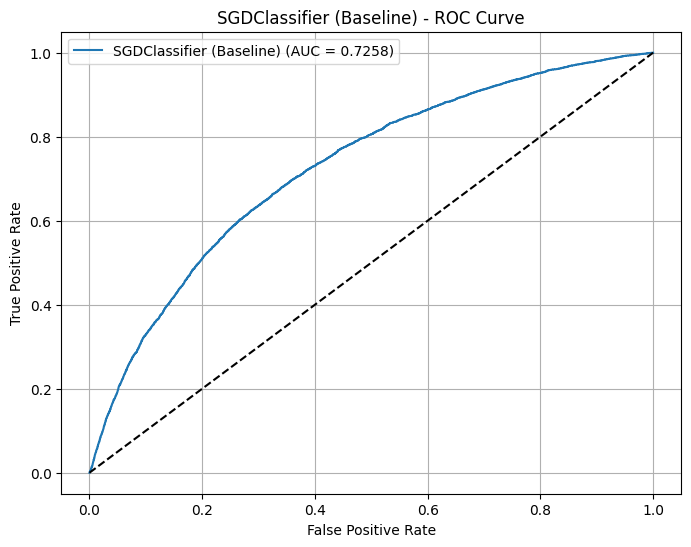

[I 2025-04-07 13:58:26,812] Using an existing study with name 'sgd_optimization' instead of creating a new one.



--- Optuna Optimization for SGDClassifier ---
Starting Optuna optimization for SGD with max 20 trials (early stopping enabled)...


[I 2025-04-07 13:59:20,177] Trial 135 finished with value: 0.7523631281581341 and parameters: {'alpha': 0.0009566566215988224, 'max_iter': 1663, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.012504813450826296}. Best is trial 52 with value: 0.7524311472398143.
[I 2025-04-07 14:00:08,467] Trial 136 finished with value: 0.752334069366193 and parameters: {'alpha': 0.0010615264269681875, 'max_iter': 1657, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01200615545847592}. Best is trial 52 with value: 0.7524311472398143.


No improvement for 1/5 trials. Current best: 0.7524


[I 2025-04-07 14:00:59,751] Trial 137 finished with value: 0.7523676135566756 and parameters: {'alpha': 0.0009678420859490772, 'max_iter': 1674, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.020979531244246036}. Best is trial 52 with value: 0.7524311472398143.


No improvement for 2/5 trials. Current best: 0.7524


[I 2025-04-07 14:01:48,292] Trial 138 finished with value: 0.7524510482039067 and parameters: {'alpha': 0.0012153669823511818, 'max_iter': 1712, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02123148730450329}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 3/5 trials. Current best: 0.7524


[I 2025-04-07 14:02:36,491] Trial 139 finished with value: 0.7523404005802674 and parameters: {'alpha': 0.0011233333192578292, 'max_iter': 1732, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009373534876474066}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 4/5 trials. Current best: 0.7524


[I 2025-04-07 14:03:28,605] Trial 140 finished with value: 0.7522804316144605 and parameters: {'alpha': 0.0012271841985949928, 'max_iter': 1731, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.020413891482337198}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 5/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:03:57,425] Trial 141 finished with value: 0.7519786841926963 and parameters: {'alpha': 0.0020096979786341077, 'max_iter': 1872, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009684848658245883}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 6/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:04:29,267] Trial 142 finished with value: 0.7502271755836144 and parameters: {'alpha': 0.0010907934879404882, 'max_iter': 1665, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 7/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:05:21,812] Trial 143 finished with value: 0.7521988516889891 and parameters: {'alpha': 0.0031020364076466927, 'max_iter': 1829, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004087680230841034}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 8/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:06:09,470] Trial 144 finished with value: 0.752345167638236 and parameters: {'alpha': 0.0013086960087414765, 'max_iter': 1993, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008050029868712255}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 9/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:07:03,330] Trial 145 finished with value: 0.7522632348035222 and parameters: {'alpha': 0.0009541074815306576, 'max_iter': 2014, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.007876011706230878}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 10/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:07:51,582] Trial 146 finished with value: 0.7522989465469857 and parameters: {'alpha': 0.0018023665540360815, 'max_iter': 2111, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0069137203298572265}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 11/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:08:41,781] Trial 147 finished with value: 0.7524096876860079 and parameters: {'alpha': 0.0013134576325147084, 'max_iter': 1728, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005362720104254548}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 12/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:09:30,258] Trial 148 finished with value: 0.7523663466458939 and parameters: {'alpha': 0.001289878239844882, 'max_iter': 1735, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005407851170876532}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 13/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:10:17,288] Trial 149 finished with value: 0.7521502860334977 and parameters: {'alpha': 0.0005639260783881618, 'max_iter': 1742, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005404226095356874}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 14/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:11:05,376] Trial 150 finished with value: 0.7523378912508278 and parameters: {'alpha': 0.0012183153500531585, 'max_iter': 1944, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0035042963717335143}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 15/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:11:51,537] Trial 151 finished with value: 0.7523773681017292 and parameters: {'alpha': 0.0012804655298647883, 'max_iter': 1961, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0030791125908235855}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 16/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:12:11,424] Trial 152 finished with value: 0.717522486052125 and parameters: {'alpha': 0.0023469720064769216, 'max_iter': 2050, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.002893227333527525}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 17/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:12:57,667] Trial 153 finished with value: 0.7523391770873419 and parameters: {'alpha': 0.0012979203566112717, 'max_iter': 1955, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0021845320614653162}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 18/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 14:14:28,125] Trial 154 finished with value: 0.7506025552365865 and parameters: {'alpha': 0.000792302179935353, 'max_iter': 1963, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.0022207499528557983}. Best is trial 138 with value: 0.7524510482039067.


No improvement for 19/5 trials. Current best: 0.7524
Early stopping triggered after 5 trials without 0.0010 improvement
Optuna optimization completed in 16.02 minutes

Best Params (SGDClassifier): {'alpha': 0.0012153669823511818, 'max_iter': 1712, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02123148730450329}
Best CV ROC AUC score: 0.7525

Fitting best SGD pipeline on full training data...

Evaluating tuned SGD model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.4855

--- Evaluation Metrics for SGDClassifier (Optuna Tuned) ---
AUC ROC:        0.7564
Gini Coefficient: 0.5129
KS Statistic:   0.3775
Accuracy:       0.6754
Precision:      0.1585
Recall (TPR):   0.7009
F1-Score:       0.2585
Brier Score:    0.2002
Log Loss:       0.5868

Confusion Matrix:
[[38056 18481]
 [ 1485  3480]]


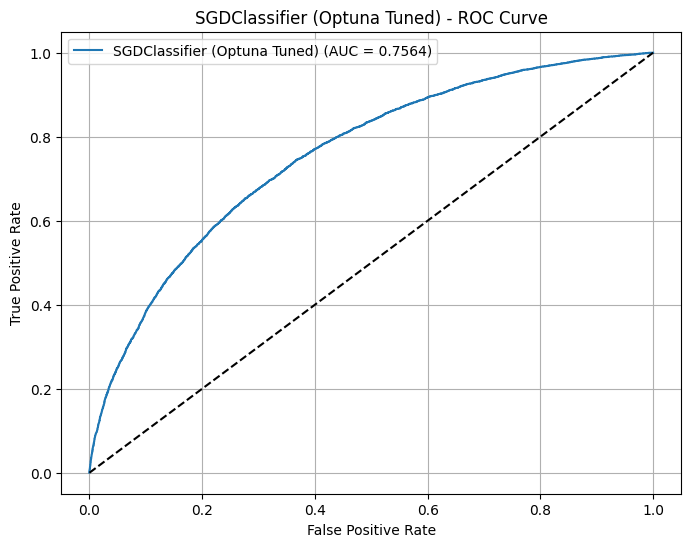


--- Top 50 Feature Importances ---
Sum of importances: 9.4666


,feature,importance
80,EXT_SOURCE_MEAN,0.25940
83,WEIGHTED_EXT_SOURCE,0.25294
47,FLAG_DOCUMENT_3,0.23492
143,AGE_EMPLOYED_DIFF_MEAN_AGG_OCCUPATION_TYPE_ORG...,0.21746
151,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.18679
415,B_B_CURRENT_CREDIT_DEBT_DIFF_SUM_OVERALL,0.17772
135,AGE_EMPLOYED_DIFF_MIN_AGG_NAME_EDUCATION_TYPE_...,0.15690
24,EXT_SOURCE_1,0.15488
134,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.14378
26,EXT_SOURCE_3,0.14136


In [42]:
# --- Model 2: SGDClassifier with Optuna Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Optuna Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline (No change needed here)
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    # ('smote', SMOTE_VARIANT), # Keep SMOTE here
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED,
                            class_weight='balanced', n_jobs=8, tol=1e-5))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for SGDClassifier ---")

# Define the objective function for Optuna
def objective_sgd(trial):
    # Define hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    l1_ratio = 0.15 # Default if penalty is elasticnet, fixed here for simplicity, could also tune
    class_weight_opt = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    eta0 = 0.01 
    if learning_rate != 'optimal':
        eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True)

    # Create the pipeline with suggested parameters
    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', SGDClassifier(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else 0.15, # Apply l1_ratio only if relevant
            max_iter=max_iter,
            class_weight=class_weight_opt,
            learning_rate=learning_rate,
            eta0=eta0,
            random_state=SEED,
            n_jobs=5,
            tol=1e-5 # Use tolerance for convergence
        ))
    ])

    # Evaluate using cross-validation
    try:
        # Using roc_auc as the optimization target
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        # Handle potential errors during CV
        if np.isnan(auc_score):
            return 0.0 # Return low score if CV fails
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0 # Return low score for failed trials

# Create an Optuna study
study_sgd = optuna.create_study(direction='maximize',
                                study_name='sgd_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db', # Save study progress
                                load_if_exists=True) # Resume if exists

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for SGD with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build the final pipeline
best_params_sgd_raw = study_sgd.best_params
# Need to prefix with 'model__' for pipeline
best_params_sgd = {f'model__{k}': v for k, v in best_params_sgd_raw.items()}
print(f"\nBest Params (SGDClassifier): {best_params_sgd_raw}")
print(f"Best CV ROC AUC score: {study_sgd.best_value:.4f}")

best_sgd_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=SEED, n_jobs=8, tol=1e-5, class_weight='balanced'))
])
best_sgd_pipeline.set_params(**best_params_sgd)

# Fit the best pipeline on the full training data
print("\nFitting best SGD pipeline on full training data...")
best_sgd_pipeline.fit(X_train, y_train)

# Step 2.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned SGD model...")
y_prob_oof_sgd = cross_val_predict(best_sgd_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_sgd_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Optuna Tuned)")

# Feature importance via coefficients
final_sgd_model = best_sgd_pipeline.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
     get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_sgd_pipeline # Store the best pipeline

# 5. Model 3: XGBoost


Model 3: XGBoost with Optuna Optimization & GPU

--- Baseline XGBoost Training ---

--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7545
Gini Coefficient: 0.5089
KS Statistic:   0.3791
Accuracy:       0.7538
Precision:      0.1853
Recall (TPR):   0.6036
F1-Score:       0.2836
Brier Score:    0.1648
Log Loss:       0.4961

Confusion Matrix:
[[43363 13174]
 [ 1968  2997]]


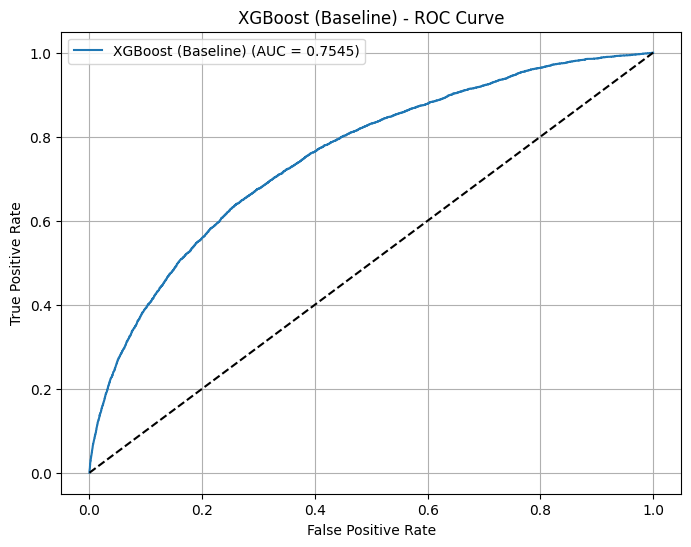


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
83,WEIGHTED_EXT_SOURCE,0.03284
80,EXT_SOURCE_MEAN,0.02404
151,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.00745
60,CREDIT_GOODS_DIFF,0.00640
91,DEF_30_60_SUM,0.00623
412,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.00569
77,REGION_RATING_MEAN,0.00559
407,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_OVERALL,0.00533
47,FLAG_DOCUMENT_3,0.00515
149,AMT_ANNUITY_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_F...,0.00515


[I 2025-04-07 14:16:15,575] Using an existing study with name 'xgb_optimization' instead of creating a new one.



--- Optuna Optimization for XGBoost ---
Starting Optuna optimization for XGBoost with max 20 trials (early stopping enabled)...


[I 2025-04-07 14:19:35,945] Trial 137 finished with value: 0.7668327010023536 and parameters: {'n_estimators': 903, 'max_depth': 7, 'learning_rate': 0.017317335184557452, 'subsample': 0.9849432658962246, 'colsample_bytree': 0.6639026760509357, 'gamma': 0.35001668048620527, 'reg_alpha': 0.3964812766119101, 'reg_lambda': 1.3778789444461265e-08}. Best is trial 135 with value: 0.7746124371852164.
[I 2025-04-07 14:23:07,239] Trial 138 finished with value: 0.7680185272676494 and parameters: {'n_estimators': 916, 'max_depth': 7, 'learning_rate': 0.014705365874831861, 'subsample': 0.9546615249700567, 'colsample_bytree': 0.666188144787297, 'gamma': 0.4046798578725878, 'reg_alpha': 0.5891029301821166, 'reg_lambda': 6.759741332538218e-08}. Best is trial 135 with value: 0.7746124371852164.


New best score: 0.7680


[I 2025-04-07 14:26:23,891] Trial 139 finished with value: 0.7665347749085848 and parameters: {'n_estimators': 890, 'max_depth': 7, 'learning_rate': 0.019059102728115163, 'subsample': 0.9438269969642074, 'colsample_bytree': 0.6367084296657812, 'gamma': 0.36513476580458964, 'reg_alpha': 0.13099984665462935, 'reg_lambda': 1.7741717283916464e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 1/5 trials. Current best: 0.7680


[I 2025-04-07 14:29:47,552] Trial 140 finished with value: 0.7673068106340439 and parameters: {'n_estimators': 913, 'max_depth': 7, 'learning_rate': 0.01798605270829651, 'subsample': 0.9716287055587873, 'colsample_bytree': 0.6782608048789073, 'gamma': 0.3398969214792822, 'reg_alpha': 0.9245776622313734, 'reg_lambda': 1.0307958411806852e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 2/5 trials. Current best: 0.7680


[I 2025-04-07 14:33:15,898] Trial 141 finished with value: 0.7667172022682289 and parameters: {'n_estimators': 932, 'max_depth': 7, 'learning_rate': 0.015885212314036536, 'subsample': 0.9952484169828983, 'colsample_bytree': 0.6979780120427481, 'gamma': 0.3314834830703358, 'reg_alpha': 0.3749318587143596, 'reg_lambda': 1.1424216435148752e-07}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 3/5 trials. Current best: 0.7680


[I 2025-04-07 14:36:41,569] Trial 142 finished with value: 0.7674393764821771 and parameters: {'n_estimators': 887, 'max_depth': 7, 'learning_rate': 0.014994533991005586, 'subsample': 0.6298768770427339, 'colsample_bytree': 0.6560202840610596, 'gamma': 0.354283540757198, 'reg_alpha': 0.2397759902867215, 'reg_lambda': 4.685938060834119e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 4/5 trials. Current best: 0.7680


[I 2025-04-07 14:40:02,576] Trial 143 finished with value: 0.7691018885053051 and parameters: {'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.012582354432737974, 'subsample': 0.9752578752749664, 'colsample_bytree': 0.6114107673068192, 'gamma': 0.32787869961444654, 'reg_alpha': 0.2706053766437932, 'reg_lambda': 2.0383733859057844e-08}. Best is trial 135 with value: 0.7746124371852164.


New best score: 0.7691


[I 2025-04-07 14:44:12,851] Trial 144 finished with value: 0.7631620068062721 and parameters: {'n_estimators': 882, 'max_depth': 8, 'learning_rate': 0.01629818480966724, 'subsample': 0.9840738585683555, 'colsample_bytree': 0.6404047729579153, 'gamma': 0.2850911695630742, 'reg_alpha': 0.5354550676969417, 'reg_lambda': 2.6066603954787427e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 1/5 trials. Current best: 0.7691


[I 2025-04-07 14:48:42,305] Trial 145 finished with value: 0.7635010607427611 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.013952753368770396, 'subsample': 0.9592859914559525, 'colsample_bytree': 0.6271860425428082, 'gamma': 0.36949094718864023, 'reg_alpha': 0.15544675668690708, 'reg_lambda': 7.10990921878275e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 2/5 trials. Current best: 0.7691


[I 2025-04-07 14:52:51,388] Trial 146 finished with value: 0.7626085488155978 and parameters: {'n_estimators': 560, 'max_depth': 9, 'learning_rate': 0.01166394443276337, 'subsample': 0.9488782500992315, 'colsample_bytree': 0.6290100968579121, 'gamma': 0.3158613078872289, 'reg_alpha': 0.050954210085826845, 'reg_lambda': 4.197936532766298e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 3/5 trials. Current best: 0.7691


[I 2025-04-07 14:56:15,498] Trial 147 finished with value: 0.7679085047498133 and parameters: {'n_estimators': 903, 'max_depth': 7, 'learning_rate': 0.014917801419593741, 'subsample': 0.9746293564847979, 'colsample_bytree': 0.646479550005905, 'gamma': 0.2980930666224581, 'reg_alpha': 0.3236825720811329, 'reg_lambda': 1.7320139652236248e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 4/5 trials. Current best: 0.7691


[I 2025-04-07 14:59:10,426] Trial 148 finished with value: 0.768356061579167 and parameters: {'n_estimators': 680, 'max_depth': 7, 'learning_rate': 0.011010775067519251, 'subsample': 0.9370896405592509, 'colsample_bytree': 0.611286944735888, 'gamma': 0.34495939826381533, 'reg_alpha': 0.0920905624262172, 'reg_lambda': 1.6227038171490858e-07}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 5/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 15:03:26,003] Trial 149 finished with value: 0.7610993964539456 and parameters: {'n_estimators': 928, 'max_depth': 8, 'learning_rate': 0.01812131340047964, 'subsample': 0.9697603249443794, 'colsample_bytree': 0.638154010656616, 'gamma': 0.3330498794828276, 'reg_alpha': 0.6974335156845928, 'reg_lambda': 5.3865883435094587e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 6/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 15:08:07,108] Trial 150 finished with value: 0.7649300459291897 and parameters: {'n_estimators': 944, 'max_depth': 8, 'learning_rate': 0.012762689150976971, 'subsample': 0.9609201121739969, 'colsample_bytree': 0.678040416407465, 'gamma': 0.27688798431182027, 'reg_alpha': 0.9823140313178294, 'reg_lambda': 9.713757002914887e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 7/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 15:10:43,759] Trial 151 finished with value: 0.7684105086842726 and parameters: {'n_estimators': 629, 'max_depth': 7, 'learning_rate': 0.016577900198911064, 'subsample': 0.9514128626723458, 'colsample_bytree': 0.6155074130889298, 'gamma': 0.3893996567566963, 'reg_alpha': 0.4467687389131898, 'reg_lambda': 2.694012693232712e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 8/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 15:14:56,558] Trial 152 finished with value: 0.7639129180747133 and parameters: {'n_estimators': 870, 'max_depth': 8, 'learning_rate': 0.01414184562857734, 'subsample': 0.9911810916922347, 'colsample_bytree': 0.651294427668025, 'gamma': 0.31650421230871134, 'reg_alpha': 0.5282947357399607, 'reg_lambda': 2.054461649078625e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 9/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 15:19:03,175] Trial 153 finished with value: 0.7645822098963009 and parameters: {'n_estimators': 834, 'max_depth': 8, 'learning_rate': 0.013827785752455612, 'subsample': 0.9847687110894502, 'colsample_bytree': 0.6610740904938808, 'gamma': 0.3162386000931356, 'reg_alpha': 0.23456453271555008, 'reg_lambda': 3.674937222038833e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 10/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement
Timeout: optimization stopped after 62.79 minutes


[I 2025-04-07 15:23:11,537] Trial 154 finished with value: 0.7636716706525373 and parameters: {'n_estimators': 858, 'max_depth': 8, 'learning_rate': 0.015395854216268308, 'subsample': 0.9800008914843286, 'colsample_bytree': 0.6569876836706228, 'gamma': 0.30419052395106627, 'reg_alpha': 0.47047741826981837, 'reg_lambda': 1.3987471942293043e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 11/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement
Timeout: optimization stopped after 66.93 minutes


[I 2025-04-07 15:27:27,623] Trial 155 finished with value: 0.7154264083255232 and parameters: {'n_estimators': 915, 'max_depth': 8, 'learning_rate': 0.15037620693107057, 'subsample': 0.9938860543111385, 'colsample_bytree': 0.8731606194067019, 'gamma': 0.32214073401674603, 'reg_alpha': 0.3367976927168213, 'reg_lambda': 2.4429521428312676e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 12/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement
Timeout: optimization stopped after 71.20 minutes


[I 2025-04-07 15:31:20,717] Trial 156 finished with value: 0.7624946543156004 and parameters: {'n_estimators': 811, 'max_depth': 8, 'learning_rate': 0.019179578342156615, 'subsample': 0.9689835641763788, 'colsample_bytree': 0.6711809331551026, 'gamma': 0.29065686521437073, 'reg_alpha': 0.692815147410388, 'reg_lambda': 6.032340325469269e-08}. Best is trial 135 with value: 0.7746124371852164.


No improvement for 13/5 trials. Current best: 0.7691
Early stopping triggered after 5 trials without 0.0010 improvement
Timeout: optimization stopped after 75.09 minutes
Optuna optimization completed in 75.09 minutes

Best Params (XGBoost): {'n_estimators': 903, 'max_depth': 7, 'learning_rate': 0.018373749408140936, 'subsample': 0.9736004766137231, 'colsample_bytree': 0.6572788486775967, 'gamma': 0.3520495537145163, 'reg_alpha': 0.3631181510834995, 'reg_lambda': 1.570732200197017e-08}
Best CV ROC AUC score: 0.7746

Fitting best XGBoost pipeline on full training data...

Evaluating tuned XGBoost model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.0681

--- Evaluation Metrics for XGBoost (Optuna Tuned) ---
AUC ROC:        0.7777
Gini Coefficient: 0.5555
KS Statistic:   0.4160
Accuracy:       0.6707
Precision:      0.1636
Recall (TPR):   0.7488
F1-Score:       0.2685
Brier Score:    0.0663
Log Loss:       0.2395

Confusion Matrix:
[[37530 19007]
 [ 1247  3718]]


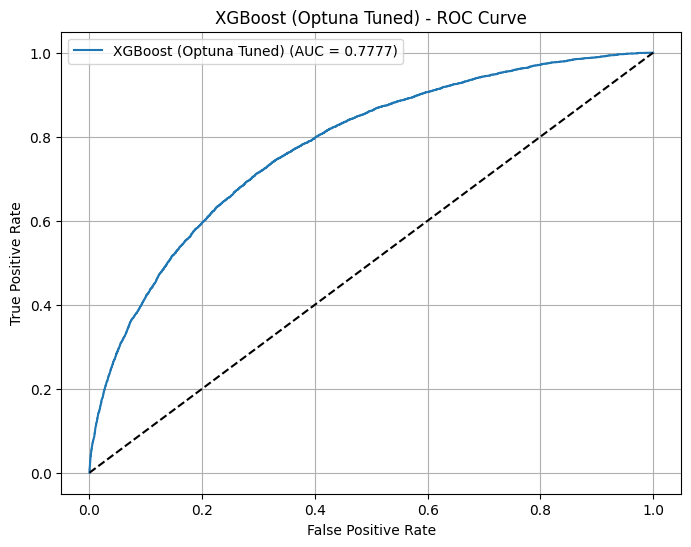


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
83,WEIGHTED_EXT_SOURCE,0.03845
80,EXT_SOURCE_MEAN,0.03019
82,EXT_SOURCE_MIN,0.00771
81,EXT_SOURCE_MAX,0.00612
47,FLAG_DOCUMENT_3,0.00420
59,CREDIT_GOODS_RATIO,0.00410
151,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.00393
26,EXT_SOURCE_3,0.00390
57,CREDIT_ANNUITY_RATIO,0.00380
60,CREDIT_GOODS_DIFF,0.00366


In [43]:
# --- Model 3: XGBoost with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 3: XGBoost with Optuna Optimization & GPU")
print("="*60)

# Step 3.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=11.5,
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU if available
                               ))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "XGBoost (Baseline)")
get_feature_importance(xgb_base_pipeline.named_steps['model'], feature_names)

# Step 3.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for XGBoost ---")

def objective_xgb(trial):
    # Define hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': SEED,
        'n_jobs': 6,
        'scale_pos_weight' : 11.5,
        'tree_method': 'gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_xgb = optuna.create_study(direction='maximize',
                                study_name='xgb_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for XGBoost with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_xgb_raw = study_xgb.best_params
best_params_xgb = {f'model__{k}': v for k, v in best_params_xgb_raw.items()}
print(f"\nBest Params (XGBoost): {best_params_xgb_raw}")
print(f"Best CV ROC AUC score: {study_xgb.best_value:.4f}")

best_xgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'))
])
# Update only the tuned parameters
best_xgb_pipeline.set_params(**best_params_xgb)


print("\nFitting best XGBoost pipeline on full training data...")
best_xgb_pipeline.fit(X_train, y_train)

# Step 3.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned XGBoost model...")
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Optuna Tuned)")
get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline # Store the best pipeline  

# 6. Model 4: LightGBM


Model 4: LightGBM with Optuna Optimization & GPU

--- Baseline LightGBM Training ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92571
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 516
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 205 dense feature groups (48.80 MB) transferred to GPU in 0.017088 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469

--- Evaluation Metrics for LightGBM (Baseline) ---
AUC ROC:        0.7751
Gini Coefficient: 0.5502
KS Statistic:   0.4137
Accuracy:       0.7140
Precision:      0.1766
Rec

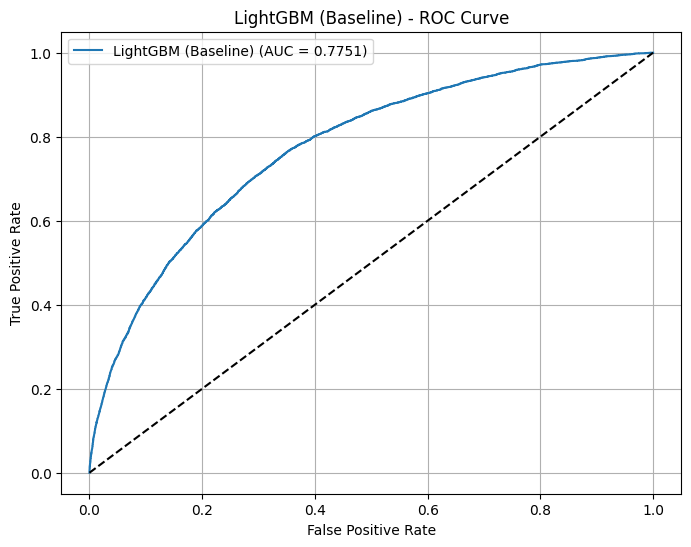


--- Top 50 Feature Importances ---
Sum of importances: 3000.0000


,feature,importance
57,CREDIT_ANNUITY_RATIO,218
5,DAYS_BIRTH,70
83,WEIGHTED_EXT_SOURCE,53
408,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,52
80,EXT_SOURCE_MEAN,51
64,AGE_EMPLOYED_DIFF,48
3,AMT_ANNUITY,45
8,DAYS_ID_PUBLISH,43
25,EXT_SOURCE_2,41
59,CREDIT_GOODS_RATIO,40


[I 2025-04-07 15:35:40,176] Using an existing study with name 'lgbm_optimization' instead of creating a new one.



--- Optuna Optimization for LightGBM ---
Starting Optuna optimization for LightGBM with max 20 trials (early stopping enabled)...


[I 2025-04-07 15:37:11,162] Trial 44 finished with value: 0.7633156698361033 and parameters: {'n_estimators': 177, 'learning_rate': 0.01714832926981629, 'num_leaves': 42, 'max_depth': 9, 'subsample': 0.8150778231805744, 'colsample_bytree': 0.663991957689337, 'reg_alpha': 5.629226854547347e-07, 'reg_lambda': 0.0009169937465716638}. Best is trial 39 with value: 0.7736317691972663.
[I 2025-04-07 15:41:02,518] Trial 45 finished with value: 0.7699673767133828 and parameters: {'n_estimators': 686, 'learning_rate': 0.012358359358990769, 'num_leaves': 100, 'max_depth': 5, 'subsample': 0.7740831078747472, 'colsample_bytree': 0.7849780106071107, 'reg_alpha': 2.2714604008661097e-07, 'reg_lambda': 0.3807528077562191}. Best is trial 39 with value: 0.7736317691972663.


New best score: 0.7700


[I 2025-04-07 15:45:29,493] Trial 46 finished with value: 0.7660060417171678 and parameters: {'n_estimators': 941, 'learning_rate': 0.05496564357918621, 'num_leaves': 25, 'max_depth': 7, 'subsample': 0.7304458823664364, 'colsample_bytree': 0.710255340520389, 'reg_alpha': 9.105033816793754e-05, 'reg_lambda': 0.08286789665530582}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 1/5 trials. Current best: 0.7700


[I 2025-04-07 15:48:19,415] Trial 47 finished with value: 0.7609475653236678 and parameters: {'n_estimators': 501, 'learning_rate': 0.08497149404473452, 'num_leaves': 38, 'max_depth': 11, 'subsample': 0.70260175036829, 'colsample_bytree': 0.7465681319097454, 'reg_alpha': 0.000638718225503189, 'reg_lambda': 5.325374871252744e-05}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 2/5 trials. Current best: 0.7700


[I 2025-04-07 15:54:22,335] Trial 48 finished with value: 0.7720132071775193 and parameters: {'n_estimators': 879, 'learning_rate': 0.020019047883657572, 'num_leaves': 47, 'max_depth': 12, 'subsample': 0.9392370873036375, 'colsample_bytree': 0.6869704672442227, 'reg_alpha': 1.555072353805269e-05, 'reg_lambda': 0.028311898484126623}. Best is trial 39 with value: 0.7736317691972663.


New best score: 0.7720


[I 2025-04-07 15:57:30,669] Trial 49 finished with value: 0.7265453400316175 and parameters: {'n_estimators': 647, 'learning_rate': 0.2527464065226839, 'num_leaves': 31, 'max_depth': 6, 'subsample': 0.638699457574529, 'colsample_bytree': 0.6009016763527173, 'reg_alpha': 5.211231668822284e-06, 'reg_lambda': 0.004388558270550249}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 1/5 trials. Current best: 0.7720


[I 2025-04-07 16:00:25,375] Trial 50 finished with value: 0.7719801617357452 and parameters: {'n_estimators': 354, 'learning_rate': 0.030110157374903846, 'num_leaves': 59, 'max_depth': 9, 'subsample': 0.908718138250955, 'colsample_bytree': 0.6576632771634597, 'reg_alpha': 4.082565521307233e-08, 'reg_lambda': 0.2273108770140731}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 2/5 trials. Current best: 0.7720


[I 2025-04-07 16:04:04,446] Trial 51 finished with value: 0.7694015106786664 and parameters: {'n_estimators': 747, 'learning_rate': 0.014871247448234065, 'num_leaves': 52, 'max_depth': 4, 'subsample': 0.8741558363655295, 'colsample_bytree': 0.8619880471720079, 'reg_alpha': 0.010900930634121607, 'reg_lambda': 0.00978398629302568}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 3/5 trials. Current best: 0.7720


[I 2025-04-07 16:08:41,919] Trial 52 finished with value: 0.7716276744258384 and parameters: {'n_estimators': 540, 'learning_rate': 0.023757129387502615, 'num_leaves': 64, 'max_depth': 8, 'subsample': 0.7880325538318058, 'colsample_bytree': 0.6227387420100929, 'reg_alpha': 1.468141139616852e-06, 'reg_lambda': 0.5424124900388461}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 4/5 trials. Current best: 0.7720


[I 2025-04-07 16:13:07,335] Trial 53 finished with value: 0.7719887985493181 and parameters: {'n_estimators': 483, 'learning_rate': 0.026247743581057314, 'num_leaves': 72, 'max_depth': 10, 'subsample': 0.7699939823321238, 'colsample_bytree': 0.6330446693343234, 'reg_alpha': 8.457962650835919e-07, 'reg_lambda': 0.1566846538760078}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 5/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:17:44,386] Trial 54 finished with value: 0.7637810213068787 and parameters: {'n_estimators': 573, 'learning_rate': 0.041189383201276866, 'num_leaves': 84, 'max_depth': 8, 'subsample': 0.8503557100953997, 'colsample_bytree': 0.7579491932761944, 'reg_alpha': 2.6864563978294076e-06, 'reg_lambda': 0.7201123921771757}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 6/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:22:11,117] Trial 55 finished with value: 0.7685369498314686 and parameters: {'n_estimators': 715, 'learning_rate': 0.03546542854817848, 'num_leaves': 65, 'max_depth': 6, 'subsample': 0.7379456345138429, 'colsample_bytree': 0.7176601728782891, 'reg_alpha': 1.5475319386279064e-07, 'reg_lambda': 0.33359503759386344}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 7/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:26:55,600] Trial 56 finished with value: 0.7720654332922824 and parameters: {'n_estimators': 819, 'learning_rate': 0.018738942408811965, 'num_leaves': 36, 'max_depth': 5, 'subsample': 0.9228026404974391, 'colsample_bytree': 0.6927545738505547, 'reg_alpha': 0.0001684212352234025, 'reg_lambda': 0.09907423369827707}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 8/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:30:16,167] Trial 57 finished with value: 0.7723142064762208 and parameters: {'n_estimators': 428, 'learning_rate': 0.023594723341911664, 'num_leaves': 45, 'max_depth': 7, 'subsample': 0.8116806387618399, 'colsample_bytree': 0.67354952047731, 'reg_alpha': 8.257050730728543e-06, 'reg_lambda': 0.04573930311740983}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 9/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:34:30,222] Trial 58 finished with value: 0.7574761863634221 and parameters: {'n_estimators': 623, 'learning_rate': 0.05929020279145089, 'num_leaves': 68, 'max_depth': 10, 'subsample': 0.7592349071219602, 'colsample_bytree': 0.6493412203540904, 'reg_alpha': 6.285379513354617e-05, 'reg_lambda': 1.2597926630196724e-05}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 10/5 trials. Current best: 0.7720
Early stopping triggered after 5 trials without 0.0010 improvement


[I 2025-04-07 16:39:33,583] Trial 59 finished with value: 0.7730705477598979 and parameters: {'n_estimators': 890, 'learning_rate': 0.031461686797938516, 'num_leaves': 24, 'max_depth': 9, 'subsample': 0.8948013686209304, 'colsample_bytree': 0.6139440630864874, 'reg_alpha': 2.2681805374417322e-05, 'reg_lambda': 0.0016300397203039233}. Best is trial 39 with value: 0.7736317691972663.


New best score: 0.7731
Timeout: optimization stopped after 63.89 minutes


[I 2025-04-07 16:46:07,876] Trial 60 finished with value: 0.7684221752849218 and parameters: {'n_estimators': 957, 'learning_rate': 0.027316446724154966, 'num_leaves': 50, 'max_depth': 11, 'subsample': 0.8384269042140915, 'colsample_bytree': 0.63009538393117, 'reg_alpha': 0.00040425213994320163, 'reg_lambda': 0.014228920120923173}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 1/5 trials. Current best: 0.7731
Timeout: optimization stopped after 70.46 minutes


[I 2025-04-07 16:50:37,293] Trial 61 finished with value: 0.7698889985764955 and parameters: {'n_estimators': 778, 'learning_rate': 0.04245059608691583, 'num_leaves': 30, 'max_depth': 8, 'subsample': 0.9542201938642308, 'colsample_bytree': 0.8120488980054908, 'reg_alpha': 1.220329548779174e-06, 'reg_lambda': 0.9462751107799175}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 2/5 trials. Current best: 0.7731
Timeout: optimization stopped after 74.95 minutes


[I 2025-04-07 16:56:25,046] Trial 62 finished with value: 0.7729522674997729 and parameters: {'n_estimators': 844, 'learning_rate': 0.021808144025470263, 'num_leaves': 39, 'max_depth': 10, 'subsample': 0.9835605398900246, 'colsample_bytree': 0.6490350923010446, 'reg_alpha': 2.498846118380161e-05, 'reg_lambda': 0.04171534981198981}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 3/5 trials. Current best: 0.7731
Timeout: optimization stopped after 80.75 minutes


[I 2025-04-07 17:02:16,031] Trial 63 finished with value: 0.7727914767051958 and parameters: {'n_estimators': 876, 'learning_rate': 0.021493063234768697, 'num_leaves': 36, 'max_depth': 10, 'subsample': 0.9559550331791841, 'colsample_bytree': 0.6536834429219315, 'reg_alpha': 3.5161832034374684e-06, 'reg_lambda': 0.18007855511563373}. Best is trial 39 with value: 0.7736317691972663.


No improvement for 4/5 trials. Current best: 0.7731
Timeout: optimization stopped after 86.60 minutes
Optuna optimization completed in 86.60 minutes

Best Params (LightGBM): {'n_estimators': 898, 'learning_rate': 0.030632614941458202, 'num_leaves': 40, 'max_depth': 5, 'subsample': 0.7216041635594714, 'colsample_bytree': 0.6955970592094374, 'reg_alpha': 1.6506547402542452e-07, 'reg_lambda': 0.053854469685982675}
Best CV ROC AUC score: 0.7736

Fitting best LightGBM pipeline on full training data...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 92571
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 516
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Ligh

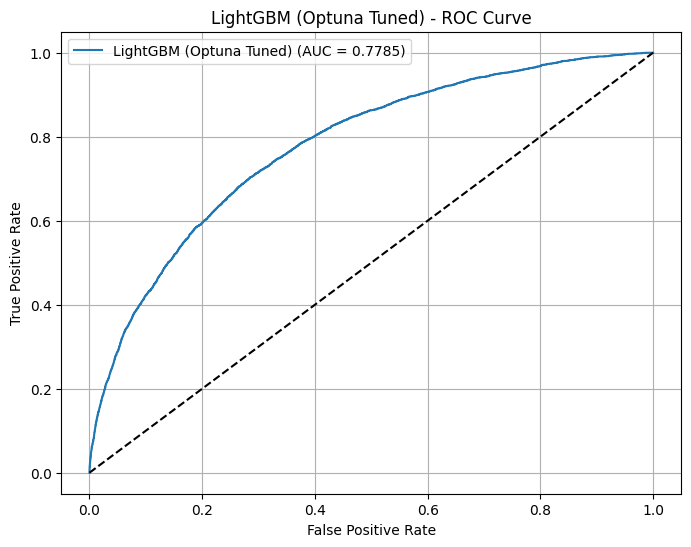


--- Top 50 Feature Importances ---
Sum of importances: 22451.0000


,feature,importance
57,CREDIT_ANNUITY_RATIO,859
5,DAYS_BIRTH,363
59,CREDIT_GOODS_RATIO,308
80,EXT_SOURCE_MEAN,289
24,EXT_SOURCE_1,252
64,AGE_EMPLOYED_DIFF,244
8,DAYS_ID_PUBLISH,244
3,AMT_ANNUITY,242
82,EXT_SOURCE_MIN,240
408,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,229


In [44]:
# --- Model 4: LightGBM with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 4: LightGBM with Optuna Optimization & GPU")
print("="*60)

# Step 4.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=6, scale_pos_weight=11.5,
                                 device='gpu' if device_name == 'cuda' else 'cpu' # Enable GPU if available
                                ))
])

lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

# Step 4.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for LightGBM ---")

def objective_lgbm(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': 5,
        'device': 'gpu' if device_name == 'cuda' else 'cpu', # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight' : 11.5,
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Optional: depends on dataset size
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        # LightGBM can sometimes throw errors with certain parameter combos
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_lgbm = optuna.create_study(direction='maximize',
                                study_name='lgbm_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for LightGBM with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_lgbm_raw = study_lgbm.best_params
best_params_lgbm = {f'model__{k}': v for k, v in best_params_lgbm_raw.items()}
print(f"\nBest Params (LightGBM): {best_params_lgbm_raw}")
print(f"Best CV ROC AUC score: {study_lgbm.best_value:.4f}")

best_lgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=5,
                                 device='gpu' if device_name == 'cuda' else 'cpu'))
])
# Update only the tuned parameters
best_lgb_pipeline.set_params(**best_params_lgbm)

print("\nFitting best LightGBM pipeline on full training data...")
best_lgb_pipeline.fit(X_train, y_train)

# Step 4.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned LightGBM model...")
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Optuna Tuned)")
get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline # Store the best pipeline

# 7. Model 5: Stacking Classifier


Model 6: Stacking Classifier
Using base models: ['SGD', 'XGB', 'LGBM']
Training Stacking Classifier...
Stacking Training Time: 7.73 minutes
Evaluating Stacking Classifier...
Getting OOF predictions for Stacking threshold tuning (may take time)...
Optimal threshold based on Youden's J-Statistic (OOF): 0.4735

--- Evaluation Metrics for Stacking Classifier ---
AUC ROC:        0.7729
Gini Coefficient: 0.5458
KS Statistic:   0.4062
Accuracy:       0.7214
Precision:      0.1775
Recall (TPR):   0.6743
F1-Score:       0.2810
Brier Score:    0.1898
Log Loss:       0.5764

Confusion Matrix:
[[41022 15515]
 [ 1617  3348]]


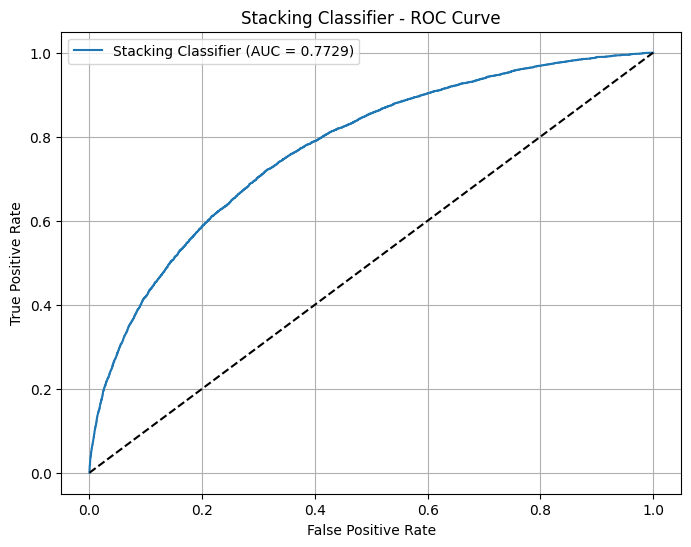


Meta-Learner Coefficients (Importance of Base Models):


,Base Model,Coefficient
2,LGBM,3.17243
1,XGB,3.09452
0,SGD,2.24201


In [45]:
# --- Model 5: Stacking Classifier ---
print("\n" + "="*60)
print("Model 6: Stacking Classifier")
print("="*60)

# Check if base models were successfully trained and stored
base_models_available = [name for name in ['LR_WOE', 'SGD', 'XGB', 'LGBM'] if name in model_objects]

if len(base_models_available) < 2:
    print("Need at least 2 successfully tuned base models to perform stacking. Skipping.")
    baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan}) # Add placeholder results
    tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
else:
    print(f"Using base models: {base_models_available}")

    # Define base estimators using the best pipelines/models found
    # Note: LR_WOE needs special handling as it uses pre-transformed data
    estimators = []
    # Need a way to handle the WOE input for the LR_WOE base model within StackingClassifier
    # This is complex. A common workaround is to retrain the non-WOE models without SMOTE/Scaling
    # within the stacking pipeline if the meta-learner benefits from raw probabilities.
    # OR, create custom transformers for WOE application within the stacking framework.
    # For simplicity here, let's use the pipelines *as is*, acknowledging potential inefficiencies.
    # We will exclude LR_WOE for now due to the input data difference.
    estimators = [(name, model_objects[name]) for name in base_models_available if name != 'LR_WOE']

    if not estimators:
         print("No suitable non-WOE base models found for stacking. Skipping.")
         baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan})
         tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
    else:
        # Define Meta Learner
        meta_learner = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=5)

        # Create Stacking Classifier
        # Use 'predict_proba' for stack_method as meta-learner often benefits from probabilities
        # `passthrough=False` means only the predictions of base models are passed to meta-learner
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=meta_learner,
            cv=cv, # Use the same CV strategy for generating base model predictions
            stack_method='predict_proba',
            n_jobs=-1,
            passthrough=False # Usually False is better unless meta-learner needs original features too
        )

        # Train the Stacking Classifier
        print("Training Stacking Classifier...")
        start_stack_time = time.time()
        stacking_clf.fit(X_train, y_train)
        end_stack_time = time.time()
        print(f"Stacking Training Time: {(end_stack_time - start_stack_time)/60:.2f} minutes")


        # Optimal Threshold and Evaluation
        # Get OOF predictions (using internal CV of StackingClassifier isn't straightforward for threshold tuning)
        # Re-run cross_val_predict with the *fitted* stacking classifier is one way,
        # but might be computationally expensive as it retrains.
        # Alternative: Use the internal OOF predictions if accessible (not standard in sklearn's StackingClassifier)
        # Simplest approach for now: Use the fitted model and evaluate directly, find threshold on test preds (less ideal)
        # Or: find threshold on OOF predictions of the *meta-learner* if we could extract them.
        # Let's proceed with direct evaluation and acknowledge thresholding limitation here.

        print("Evaluating Stacking Classifier...")
        y_pred_proba_test_stack = stacking_clf.predict_proba(X_test)[:, 1]

        # Find threshold on test set probabilities (Sub-optimal, but simple for this structure)
        # Ideally, you'd get OOF predictions from the *stacking* process on the training set.
        # optimal_threshold_stack = find_optimal_threshold_j_statistic(y_test, y_pred_proba_test_stack) # Find on test for demo

        # For consistency, let's try getting OOF on train (might be slow)
        print("Getting OOF predictions for Stacking threshold tuning (may take time)...")
        y_prob_oof_stack = cross_val_predict(stacking_clf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        optimal_threshold_stack = find_optimal_threshold_j_statistic(y_train, y_prob_oof_stack)

        y_pred_bin_test_stack = (y_pred_proba_test_stack >= optimal_threshold_stack).astype(int)

        # Store as both baseline and tuned result for Stacking
        stacking_eval_results = evaluate_model(y_test, y_pred_proba_test_stack, y_pred_bin_test_stack, "Stacking Classifier")
        baseline_results.append(stacking_eval_results)
        tuned_results.append(stacking_eval_results) # No separate tuning step shown here

        plot_roc_curve(y_test, y_pred_proba_test_stack, "Stacking Classifier")
        # Feature importance for stacking is typically done via SHAP on the meta-learner or permutation importance.
        # Or examine coefficients of the meta-learner:
        if hasattr(stacking_clf.final_estimator_, 'coef_'):
            print("\nMeta-Learner Coefficients (Importance of Base Models):")
            meta_coefs = pd.DataFrame({
                'Base Model': [name for name, _ in estimators],
                'Coefficient': np.abs(stacking_clf.final_estimator_.coef_[0]) # Abs value for importance magnitude
            }).sort_values('Coefficient', ascending=False)
            display(meta_coefs)
        model_objects['Stacking'] = stacking_clf # Store the model

# 8. Model Evaluation

In [46]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model') # Now contains Optuna results

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "baseline_model_results.csv"))
tuned_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "tuned_model_results_optuna.csv")) # Updated filename
print(f"\nResults saved to {MODEL_OUTPUT_PATH}")

# Optionally save the best models
model_save_path = os.path.join(MODEL_OUTPUT_PATH, 'best_models_optuna.pkl')
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(model_objects, f)
    print(f"Best model objects saved to {model_save_path}")
except Exception as e:
    print(f"Could not save models: {e}")

# Optionally save the Optuna studies (they are also saved to the sqlite DB)
study_sgd.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_sgd_trials.csv'))
study_xgb.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_xgb_trials.csv'))
study_lgbm.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_lgbm_trials.csv'))

# Save the most important features from the best models
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.nan # Placeholder, will fill with actual importance later
})
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance_df[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance_df[model_name] = np.abs(model.coef_[0]) # For linear models
    else:
        feature_importance_df[model_name] = np.nan

feature_importance_df = feature_importance_df.set_index('Feature').fillna(0) # Fill NaN with 0 for missing models
feature_importance_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, 'feature_importances.csv'))
print(f"\nFeature importances saved to {MODEL_OUTPUT_PATH}feature_importances.csv")

print("\nModeling complete.")


Overall Model Comparison

--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Baseline),0.77510,0.55021,0.41370,0.71398,0.17659,0.69426,0.28156,0.18447,0.54468
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
XGBoost (Baseline),0.75446,0.50893,0.37912,0.75380,0.18533,0.60363,0.28359,0.16483,0.49610
SGDClassifier (Baseline),0.72580,0.45159,0.33871,0.67682,0.15228,0.65760,0.24729,0.21175,0.63249



--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Optuna Tuned),0.77845,0.55691,0.41835,0.70515,0.17482,0.71299,0.28080,0.06621,0.23923
XGBoost (Optuna Tuned),0.77773,0.55547,0.41597,0.67068,0.16361,0.74884,0.26854,0.06630,0.23952
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
SGDClassifier (Optuna Tuned),0.75644,0.51288,0.37752,0.67536,0.15846,0.70091,0.25849,0.20022,0.58677



Results saved to ./model_outputs/
Best model objects saved to ./model_outputs/best_models_optuna.pkl

Feature importances saved to ./model_outputs/feature_importances.csv

Modeling complete.
